In [1]:
from segmented_comprehension import Stack, Image
import numpy as np
import pandas as pd
from glob import glob
from natsort import natsorted
from tqdm import tqdm
import matplotlib.pyplot as plt

## create area and mitosis data for the dataset

In [2]:
stack_paths=natsorted(glob('F:/my_data/Segmentation/JohnData/180930 star mdck 2mg col wt/segmented/*'))

In [3]:
JD_2mgcol=[Stack(stack_path) for stack_path in tqdm(stack_paths)]

100%|██████████| 60/60 [00:49<00:00,  1.22it/s]


In [4]:
for stack in tqdm(JD_2mgcol):
    stack.track_centroids(filter_stubs=False)
    areas=[]
    poly_areas=[]
    for frame in stack.frames:
        areas.append(np.unique(frame.masks, 0, return_counts=True)[1][1:])
        for cell in frame.cells:
            poly_areas.append(cell.get_area())

    areas=np.concatenate(areas)
    stack.tracked_centroids=stack.tracked_centroids.sort_values(['frame','cell_number'])
    stack.tracked_centroids['area']=areas
    stack.tracked_centroids['poly_area']=poly_areas

100%|██████████| 60/60 [13:02<00:00, 13.04s/it]


In [5]:
mitoses=[]
tracked_centroids=[]
for stack_number, stack in enumerate(tqdm(JD_2mgcol)):
    m=pd.concat(stack.get_mitoses()).reset_index()[['particle','frame']]
    t=stack.tracked_centroids.copy()
    m['stack_number']=stack_number+1
    t['stack_number']=stack_number+1
    mitoses.append(m)
    tracked_centroids.append(t)
tracked_centroids=pd.concat(tracked_centroids)
mitoses=pd.concat(mitoses)

100%|██████████| 60/60 [05:21<00:00,  5.35s/it]


In [6]:
tracked_centroids['unique_particle']=tracked_centroids.groupby(['stack_number', 'particle']).ngroup()
mapping=tracked_centroids[['unique_particle', 'stack_number', 'particle']].drop_duplicates(keep='first').set_index(['stack_number', 'particle'])

In [7]:
mitoses=mitoses.reset_index(drop=True)
mitoses['unique_particle']=mapping.reindex(pd.MultiIndex.from_frame(mitoses[['stack_number','particle']])).reset_index(drop=True)

In [297]:
cell_list=[]
particle_of_interest=42541
for _, row in tracked_centroids[['cell_number','frame','stack_number']][tracked_centroids.unique_particle==particle_of_interest].iterrows():
    cell_list.append(JD_2mgcol[row['stack_number']-1].frames[row['frame']].cells[row['cell_number']])

In [ ]:
import pickle
with open('RAM_dump/2mgcol_tracked_centroids.pkl', 'rb') as file:
    tracked_centroids=pickle.load(file)

with open('RAM_dump/2mgcol_mitoses.pkl', 'rb') as file:
    mitoses=pickle.load(file)

In [ ]:
import pickle
with open('RAM_dump/2mgcol_tracked_centroids.pkl', 'wb') as file:
    pickle.dump(tracked_centroids, file)

with open('RAM_dump/2mgcol_mitoses.pkl', 'wb') as file:
    pickle.dump(mitoses, file)

# Analysis

## demo cell outline over time

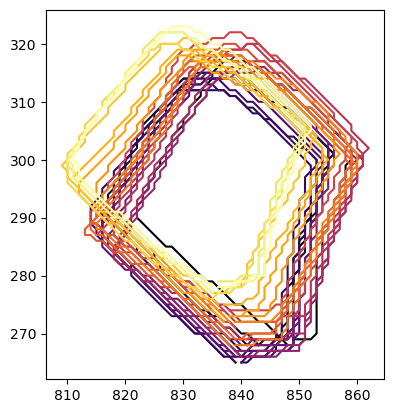

In [302]:
colors=plt.cm.inferno(np.linspace(0,1,30))
for color, cell in zip(colors, cell_list[20:50]):
    plt.plot(*cell.outline.T, color=color)
plt.gca().set_aspect(1)

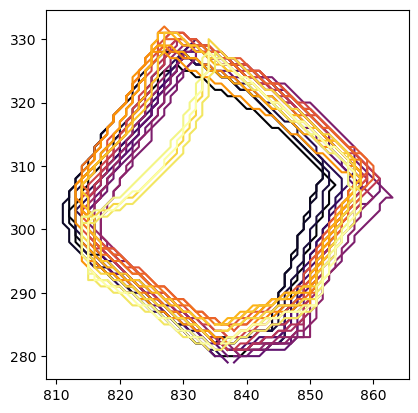

In [303]:
colors=plt.cm.inferno(np.linspace(0,1,30))
for color, cell in zip(colors, cell_list[50:80]):
    plt.plot(*cell.outline.T, color=color)
plt.gca().set_aspect(1)

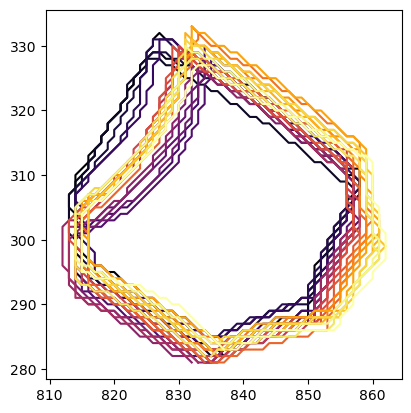

In [304]:
colors=plt.cm.inferno(np.linspace(0,1,30))
for color, cell in zip(colors, cell_list[70:100]):
    plt.plot(*cell.outline.T, color=color)
plt.gca().set_aspect(1)

## sample mitosis areas

In [320]:
import pickle
aligned_dirs=natsorted(glob('F:/my_data/Segmentation/JohnData/180930 star mdck 2mg col wt/contours/*/smoothed_contours.pkl'))
smoothed_contours=[]
for aligned_dir in tqdm(aligned_dirs):
    with open(aligned_dir, 'rb') as file:
        smoothed_contours.append(pickle.load(file))
smoothed_contours=np.concatenate(smoothed_contours)

100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


In [321]:
tracked_centroids['contour']=np.pad(smoothed_contours, (0,len(tracked_centroids)-len(smoothed_contours)), constant_values=np.nan)

In [108]:
multiple_mitoses=mitoses['unique_particle'].value_counts()>1
multiple_mitoses_IDs=multiple_mitoses.index[multiple_mitoses]
print(sorted(multiple_mitoses_IDs))

[863, 1023, 1825, 4503, 4642, 4643, 4818, 4963, 4964, 5896, 6199, 6700, 7661, 8153, 8776, 9358, 14488, 16596, 17452, 17653, 17825, 19564, 24577, 24748, 26010, 26070, 26650, 26652, 26703, 26901, 27025, 27234, 27366, 30033, 30036, 31987, 31995, 32211, 35097, 38152, 39051, 40442, 40858, 40942, 43533, 44235, 44540, 44587, 45112, 46172, 46884, 46931, 46950, 48804, 49338, 50012, 51492, 51501, 52324, 52373, 54282, 54387, 56186, 57658, 59618, 60458, 64519, 68111, 69522, 71306, 71373, 71814, 72959, 73191, 73366, 75718, 77136, 80022, 80495, 80872, 81959, 82121, 83221, 83347, 83499, 83821, 86151, 86743, 87507, 89092, 90176, 96927, 97894, 98704, 99067, 99522, 100985, 101342, 101356, 101556, 102611, 103876, 103972, 104259, 104625, 108731, 110432, 112738, 113082, 113444, 113450, 115635, 115742, 118016, 118549, 118550, 119381, 121627, 121957, 121958, 122025, 122887, 124714, 124762, 125563, 125969, 127370, 127384, 128141, 131092, 131412, 131455, 133118, 133366, 133958, 133959, 134639, 135475, 135482, 

In [215]:
for ID in sorted(multiple_mitoses_IDs):
    time_diff=np.diff(mitoses[mitoses.unique_particle==ID].frame)[0]
    if time_diff>60:
        print(ID, end=', ')

863, 4503, 4642, 4643, 4818, 4963, 4964, 7661, 8153, 16596, 19564, 26070, 31995, 32211, 40858, 48804, 49338, 52373, 72959, 80022, 86151, 97894, 103876, 104625, 113082, 115635, 118549, 118550, 121957, 121958, 122025, 124762, 131092, 133118, 148071, 148491, 172557, 175545, 176203, 

100%|██████████| 5/5 [00:00<00:00, 45.33it/s]


(-55.0, 1155.0) (42.83757421875, 260.49665390625)


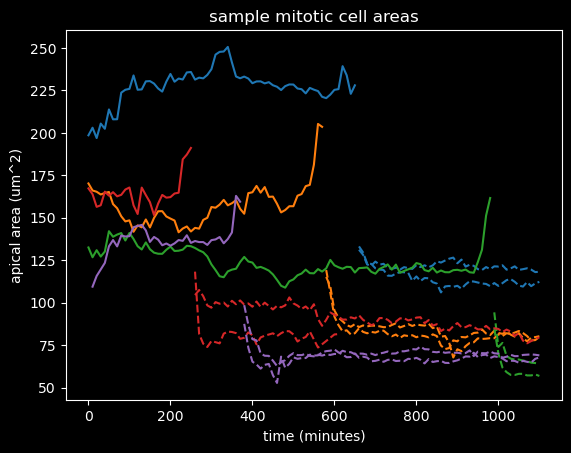

In [350]:
mitosis_IDs=np.array(np.split(mitoses['unique_particle'], len(mitoses)/3))
mitosis_numbers=(mitoses[mitoses.unique_particle==52373].index.values/3).astype(int)
#random_subset=sorted(np.random.choice(np.arange(len(mitosis_IDs)), size=5))
mitosis_numbers=[6499,9232,8589,18283,10265]
#random_subset=[9778,10034]
mitosis_subset=mitosis_IDs[mitosis_numbers]
colors=plt.cm.tab10(np.arange(len(mitosis_subset)))
for (mother_ID, daughter1_ID, daughter2_ID), color in zip(tqdm(mitosis_subset), colors):
    mother=tracked_centroids[tracked_centroids.unique_particle==mother_ID]
    daughter1=tracked_centroids[tracked_centroids.unique_particle==daughter1_ID]
    daughter2=tracked_centroids[tracked_centroids.unique_particle==daughter2_ID]
    plt.plot(mother.frame*10, mother.poly_area*0.3225**2, color=color, label=mother_ID, alpha=1)
    plt.plot(daughter1.frame*10, daughter1.poly_area*0.3225**2, '--', color=color)
    plt.plot(daughter2.frame*10, daughter2.poly_area*0.3225**2, '--', color=color)

plt.xlabel('time (minutes)')
plt.ylabel('apical area (um^2)')

plt.title('sample mitotic cell areas')
plt.savefig('plots/24-1-31 Gottardi Meeting/sample_mitotic_areas.jpg', dpi=300)
#plt.legend()
print(plt.xlim(), plt.ylim())

In [322]:
frames_to_plot=[]
cells_to_plot=np.unique(mitosis_IDs[mitosis_numbers])# one mitosis: 6499
for cell_ID in cells_to_plot:
    frames_to_plot.append(tracked_centroids[tracked_centroids.unique_particle==cell_ID])
frames_to_plot=pd.concat(frames_to_plot)
color_mapping=dict([(particle_ID, color) for particle_ID, color in zip(cells_to_plot, plt.cm.viridis(np.linspace(0.1,0.9,len(cells_to_plot))))])

area=[]
for contour in tqdm(frames_to_plot['contour']):
    points=contour.points.T
    area.append(0.5*np.abs(np.dot(points[0],np.roll(points[1],1))-np.dot(points[1],np.roll(points[0],1))))
frames_to_plot['contour_area']=area

100%|██████████| 234/234 [00:00<00:00, 22942.20it/s]


In [329]:
plt.style.use('dark_background')

for frame_number in tqdm(np.unique(frames_to_plot.frame)):
    #fig, (areaAx, outlineAx, imgAx)=plt.subplots(1,3, figsize=(12,4))
    fig, ax_dict=plt.subplot_mosaic([['area', 'img'],
                                     ['area', 'outline']],
                                     figsize=(8,4),
                                     gridspec_kw={'width_ratios':[2,1]},
                                     #subplot_kw={'aspect':1, 'adjustable':'datalim'}
                                     )
    
    areaAx=ax_dict['area']
    outlineAx=ax_dict['outline']
    imgAx=ax_dict['img']
    for unique_particle, particle_info in frames_to_plot[frames_to_plot.frame<=frame_number].groupby('unique_particle'):
        areaAx.plot(particle_info['frame']*10, particle_info['contour_area'], '-', color=color_mapping[unique_particle])
    areaAx.set_xlim(-55.0, 1155.0)
    areaAx.set_ylim(42.83757421875, 259.689340132277) #(62.44015218750001, 259.5631978125)
    areaAx.set_xlabel('time (minutes)')
    areaAx.set_ylabel('apical area (um^2)')

    #for cell_number, unique_particle in np.array(frames_to_plot[frames_to_plot.frame==frame_number][['cell_number','unique_particle']]):
    #    cell=frame.cells[cell_number]
    #    outlineAx.fill(*cell.outline.T, fc=np.append(color_mapping[unique_particle][:3],0.9), ec='white')
    for contour, unique_particle in np.array(frames_to_plot[frames_to_plot.frame==frame_number][['contour','unique_particle']]):
        outlineAx.fill(*contour.points.T, fc=np.append(color_mapping[unique_particle][:3],0.9), ec='white')
    outlineAx.set_aspect(1)
    outlineAx.set_xlim(*xlim)
    outlineAx.set_ylim(*ylim)
    outlineAx.axis('off')

    frame=JD_2mgcol[frames_to_plot['stack_number'].iloc[0]-1].frames[frame_number]
    imgAx.imshow(frame.img, cmap='gray', vmax=0.8)
    img_axlims=np.array([xlim, ylim])/0.3225
    imgAx.set_xlim(*img_axlims[0])
    imgAx.set_ylim(*img_axlims[1])
    imgAx.axis('off')

    fig.tight_layout()
    plt.savefig(f'plots/24-1-31 Gottardi Meeting/mitosis_outline_animations/frame{frame_number}.tif', dpi=300)
    plt.close()
#xlim=plt.xlim()
#ylim=plt.ylim()

100%|██████████| 111/111 [00:23<00:00,  4.72it/s]


In [316]:
frame.img.max()

1.0

## mean mitosis area

In [330]:
mother_areas=[]
daughter_areas=[]
n_frames=tracked_centroids.frame.max()
for (mother_ID, daughter1_ID, daughter2_ID) in tqdm(mitosis_IDs):
    mother=tracked_centroids[tracked_centroids.unique_particle==mother_ID]
    mother_area=mother.poly_area/mother.poly_area.iloc[-1] # normalized
    mother_areas.append(np.pad(mother_area, (n_frames-len(mother_area),0), constant_values=np.nan))

    daughter1=tracked_centroids[tracked_centroids.unique_particle==daughter1_ID]
    daughter1_area=daughter1.poly_area/mother.poly_area.iloc[-1] # normalized to mother
    daughter_areas.append(np.pad(daughter1_area, (0,n_frames-len(daughter1_area)), constant_values=np.nan))
    daughter2=tracked_centroids[tracked_centroids.unique_particle==daughter2_ID]
    daughter2_area=daughter2.poly_area/mother.poly_area.iloc[-1] # normalized to mother
    daughter_areas.append(np.pad(daughter2_area, (0,n_frames-len(daughter2_area)), constant_values=np.nan))

mother_areas=np.array(mother_areas)
daughter_areas=np.array(daughter_areas)

  0%|          | 0/23955 [00:00<?, ?it/s]

100%|██████████| 23955/23955 [06:47<00:00, 58.77it/s]


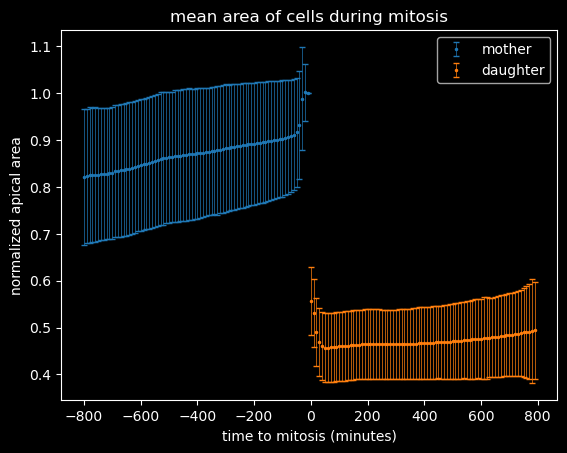

In [338]:
time_window=80
colors=plt.cm.tab10(np.arange(2))
plt.errorbar(np.arange(-time_window,0)*10,np.nanmean(mother_areas, axis=0)[n_frames-time_window:], yerr=np.nanstd(mother_areas, axis=0)[n_frames-time_window:], fmt='.', markersize=3, color=colors[0],capsize=2, linewidth=0.5, label='mother')
plt.errorbar(np.arange(0,time_window)*10,np.nanmean(daughter_areas, axis=0)[:time_window], yerr=np.nanstd(daughter_areas, axis=0)[n_frames-time_window:], fmt='.', markersize=3, color=colors[1], capsize=2, linewidth=0.5, label='daughter')

plt.ylabel('normalized apical area')
plt.xlabel('time to mitosis (minutes)')
plt.title('mean area of cells during mitosis')
plt.legend()
plt.savefig('plots/24-1-31 Gottardi Meeting/normalized_mean_mitosis_area.jpg', dpi=300)

## mean area vs time

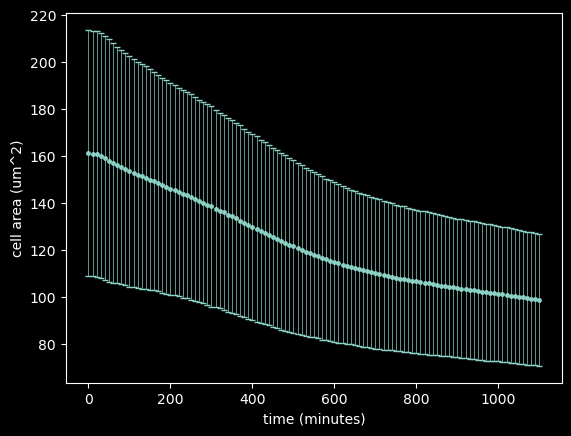

In [339]:
area_vs_time=tracked_centroids.groupby('frame')['poly_area'].agg(['mean','std'])*0.3225**2

plt.errorbar(area_vs_time.index*10,area_vs_time['mean'], yerr=area_vs_time['std'], capsize=2, markersize=5, fmt='.', linewidth=0.5)
plt.xlabel('time (minutes)')
plt.ylabel('cell area (um^2)')

plt.savefig('plots/24-1-31 Gottardi Meeting/area_vs_time.jpg', dpi=300)

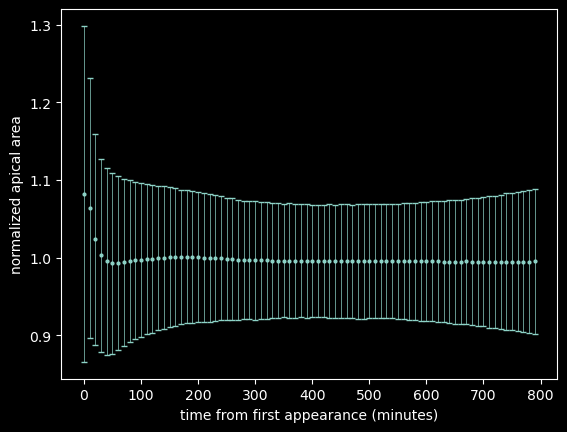

In [352]:
long_tracks=tracked_centroids[tracked_centroids.groupby('unique_particle').transform('size')>10].copy()
long_tracks['zeroed_frame']=long_tracks['frame']-long_tracks.groupby('unique_particle')['frame'].transform('min')

long_tracks=long_tracks[long_tracks.zeroed_frame<80]
long_tracks['normalized_area']=long_tracks['poly_area']/long_tracks.groupby('unique_particle')['poly_area'].transform('mean')

long_track_areas=long_tracks.groupby('zeroed_frame')['normalized_area'].agg(['mean','std'])
plt.errorbar(long_track_areas.index*10, long_track_areas['mean'], yerr=long_track_areas['std'], fmt='.', capsize=2, markersize=4, linewidth=0.5)
plt.xlabel('time from first appearance (minutes)')
plt.ylabel('normalized apical area')

plt.savefig('plots/24-1-31 Gottardi Meeting/mean_area_vs_time.jpg', dpi=300)

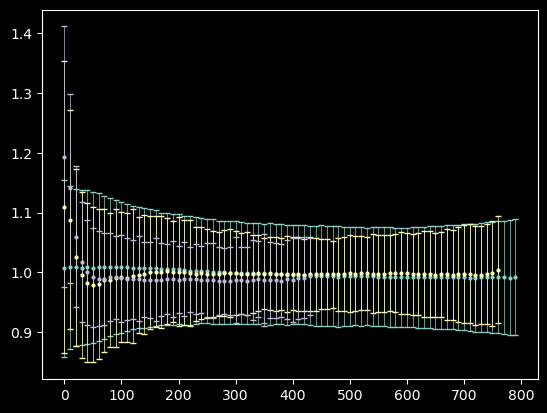

In [361]:
for n, (frame_bin, track_info) in enumerate(long_tracks.groupby(pd.cut(long_tracks['first_frame'], bins=30))):
    if n%10==0:
        long_track_areas=track_info.groupby('zeroed_frame')['normalized_area'].agg(['mean','std'])
        plt.errorbar(long_track_areas.index*10, long_track_areas['mean'], yerr=long_track_areas['std'], fmt='.', capsize=2, markersize=4, linewidth=0.5)

## cell area variation

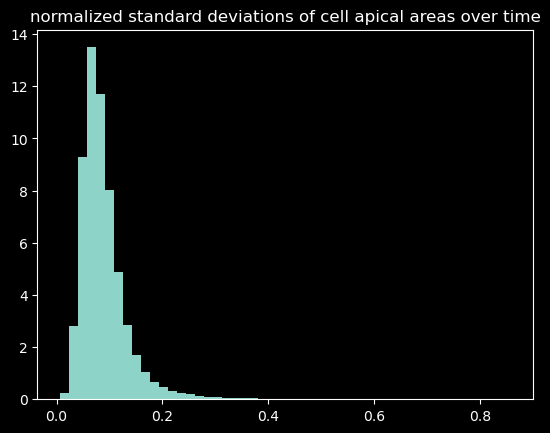

In [341]:
plt.hist(long_tracks.groupby('unique_particle')['poly_area'].std()/long_tracks.groupby('unique_particle')['poly_area'].mean(), bins=50, density=True)
plt.title('normalized standard deviations of cell apical areas over time')
plt.savefig('plots/24-1-31 Gottardi Meeting/cell_area_deviations.jpg', dpi=300)